## Midterm project

CITATIONS:
- https://github.com/poojahira/gtsrb-pytorch
- https://github.com/surajmurthy/TSR_PyTorch

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from torch.utils import data
from torch.autograd import Variable
from torchvision.io import read_image
from model import GTSRBnet

## Training

Number of training samples = 35288
Number of validation samples = 3921


Text(0, 0.5, '# of examples')

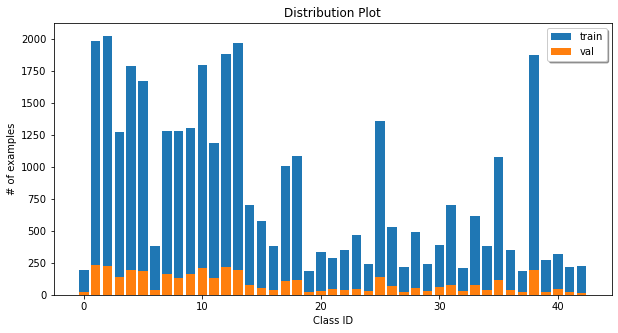

In [2]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize([212, 256]),
    transforms.ToTensor()
])

# Define path of training data
train_data_path = '/home/stringlab/Desktop/DLCV_midterm_project/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images' 
train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform=transform)

# Divide data into training and validation set
train_ratio = 0.9
n_train_examples = int(len(train_data) * train_ratio)
n_val_examples = len(train_data) - n_train_examples

train_data, val_data = data.random_split(train_data, [n_train_examples, n_val_examples])
print(f"Number of training samples = {len(train_data)}")
print(f"Number of validation samples = {len(val_data)}")

num_train_classes = len(train_data.dataset.classes)
train_hist = [0]*num_train_classes
for i in train_data.indices:
    tar = train_data.dataset.targets[i]
    train_hist[tar] += 1

num_val_classes = len(val_data.dataset.classes)
val_hist = [0]*num_val_classes
for i in val_data.indices:
    tar = val_data.dataset.targets[i]
    val_hist[tar] += 1

plt.figure(figsize=(10, 5))
plt.bar(range(num_train_classes), train_hist, label="train")
plt.bar(range(num_val_classes), val_hist, label="val")
#plt.bar(range(num_test_classes), test_hist, label="test")
legend = plt.legend(loc='upper right', shadow=True)
plt.title("Distribution Plot")
plt.xlabel("Class ID")
plt.ylabel("# of examples")

In [3]:
# Create data loader for training and validation
BATCH_SIZE = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
val_loader = data.DataLoader(val_data, shuffle=True, batch_size=BATCH_SIZE)

# Neural Network and Optimizer
model = GTSRBnet(num_train_classes)
model = model.to(device);

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

In [4]:
def train(epoch):
    model.train()
    correct = 0
    training_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)   
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        max_index = output.max(dim = 1)[1]
        correct += (max_index == target).sum()
        training_loss += loss
    avg_train_loss = training_loss / len(train_loader.dataset)
    avg_train_acc = 100. * correct / len(train_loader.dataset)
    print('\nTraining set: Average loss: {:.4f}, Accuracy: {:.0f}%\n'.format(
                avg_train_loss, avg_train_acc))
    return avg_train_loss.detach().cpu().numpy(), avg_train_acc.detach().cpu().numpy()

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, size_average=False).data.item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    scheduler.step(np.around(validation_loss,2))
    validation_acc = 100. * correct / len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {:.0f}%\n'.format(
        validation_loss, validation_acc))
    return validation_loss, validation_acc


In [5]:
train_loss, train_acc = [], []
val_loss, val_acc = [], []
for epoch in tqdm(range(1, 50)):
    avg_train_loss, avg_train_acc = train(epoch)
    avg_val_loss, avg_val_acc = validation()
    train_loss.append(avg_train_loss)
    train_acc.append(avg_train_acc)
    val_loss.append(avg_val_loss)
    val_acc.append(avg_val_acc)
    model_file = 'trained_models/model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file)

  0%|          | 0/49 [00:00<?, ?it/s]


Training set: Average loss: 0.0345, Accuracy: 8%



/home/stringlab/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Validation set: Average loss: 2.5406, Accuracy: 26%



  2%|▏         | 1/49 [00:57<46:10, 57.72s/it]


Saved model to trained_models/model_1.pth

Training set: Average loss: 0.0123, Accuracy: 62%



  4%|▍         | 2/49 [01:54<44:48, 57.20s/it]


Validation set: Average loss: 0.1819, Accuracy: 95%


Saved model to trained_models/model_2.pth

Training set: Average loss: 0.0016, Accuracy: 95%


Validation set: Average loss: 0.0679, Accuracy: 98%



  6%|▌         | 3/49 [02:52<44:10, 57.61s/it]


Saved model to trained_models/model_3.pth

Training set: Average loss: 0.0006, Accuracy: 98%



  8%|▊         | 4/49 [03:50<43:13, 57.64s/it]


Validation set: Average loss: 0.0226, Accuracy: 99%


Saved model to trained_models/model_4.pth

Training set: Average loss: 0.0004, Accuracy: 99%


Validation set: Average loss: 0.0366, Accuracy: 99%



 10%|█         | 5/49 [04:48<42:22, 57.79s/it]


Saved model to trained_models/model_5.pth

Training set: Average loss: 0.0003, Accuracy: 99%



 12%|█▏        | 6/49 [05:46<41:25, 57.79s/it]


Validation set: Average loss: 0.0284, Accuracy: 99%


Saved model to trained_models/model_6.pth

Training set: Average loss: 0.0003, Accuracy: 99%


Validation set: Average loss: 0.0131, Accuracy: 100%



 14%|█▍        | 7/49 [06:44<40:30, 57.88s/it]


Saved model to trained_models/model_7.pth

Training set: Average loss: 0.0003, Accuracy: 99%



 16%|█▋        | 8/49 [07:41<39:31, 57.83s/it]


Validation set: Average loss: 0.0428, Accuracy: 99%


Saved model to trained_models/model_8.pth

Training set: Average loss: 0.0002, Accuracy: 99%



 18%|█▊        | 9/49 [08:39<38:32, 57.82s/it]


Validation set: Average loss: 0.0333, Accuracy: 99%


Saved model to trained_models/model_9.pth

Training set: Average loss: 0.0002, Accuracy: 99%


Validation set: Average loss: 0.0174, Accuracy: 100%



 20%|██        | 10/49 [09:37<37:36, 57.87s/it]


Saved model to trained_models/model_10.pth

Training set: Average loss: 0.0002, Accuracy: 99%



 22%|██▏       | 11/49 [10:35<36:38, 57.85s/it]


Validation set: Average loss: 0.0604, Accuracy: 98%


Saved model to trained_models/model_11.pth

Training set: Average loss: 0.0002, Accuracy: 99%



 24%|██▍       | 12/49 [11:32<35:35, 57.71s/it]


Validation set: Average loss: 0.0915, Accuracy: 97%


Saved model to trained_models/model_12.pth

Training set: Average loss: 0.0002, Accuracy: 99%

Epoch    13: reducing learning rate of group 0 to 5.0000e-04.

Validation set: Average loss: 0.0117, Accuracy: 100%



 27%|██▋       | 13/49 [12:30<34:38, 57.73s/it]


Saved model to trained_models/model_13.pth

Training set: Average loss: 0.0001, Accuracy: 100%


Validation set: Average loss: 0.0094, Accuracy: 100%



 29%|██▊       | 14/49 [13:28<33:40, 57.73s/it]


Saved model to trained_models/model_14.pth

Training set: Average loss: 0.0000, Accuracy: 100%


Validation set: Average loss: 0.0082, Accuracy: 100%



 31%|███       | 15/49 [14:26<32:42, 57.73s/it]


Saved model to trained_models/model_15.pth

Training set: Average loss: 0.0000, Accuracy: 100%


Validation set: Average loss: 0.0067, Accuracy: 100%



 33%|███▎      | 16/49 [15:24<31:48, 57.84s/it]


Saved model to trained_models/model_16.pth

Training set: Average loss: 0.0000, Accuracy: 100%



 35%|███▍      | 17/49 [16:22<30:52, 57.89s/it]


Validation set: Average loss: 0.0036, Accuracy: 100%


Saved model to trained_models/model_17.pth

Training set: Average loss: 0.0001, Accuracy: 100%


Validation set: Average loss: 0.0074, Accuracy: 100%



 37%|███▋      | 18/49 [17:19<29:51, 57.78s/it]


Saved model to trained_models/model_18.pth

Training set: Average loss: 0.0001, Accuracy: 100%


Validation set: Average loss: 0.0108, Accuracy: 100%



 39%|███▉      | 19/49 [18:17<28:49, 57.65s/it]


Saved model to trained_models/model_19.pth

Training set: Average loss: 0.0001, Accuracy: 100%


Validation set: Average loss: 0.0083, Accuracy: 100%



 41%|████      | 20/49 [19:14<27:52, 57.67s/it]


Saved model to trained_models/model_20.pth

Training set: Average loss: 0.0001, Accuracy: 100%



 43%|████▎     | 21/49 [20:12<26:54, 57.66s/it]


Validation set: Average loss: 0.0050, Accuracy: 100%


Saved model to trained_models/model_21.pth

Training set: Average loss: 0.0001, Accuracy: 100%



 45%|████▍     | 22/49 [21:10<25:55, 57.61s/it]


Validation set: Average loss: 0.1197, Accuracy: 97%


Saved model to trained_models/model_22.pth

Training set: Average loss: 0.0001, Accuracy: 100%



 47%|████▋     | 23/49 [22:07<24:57, 57.60s/it]

Epoch    23: reducing learning rate of group 0 to 2.5000e-04.

Validation set: Average loss: 0.0058, Accuracy: 100%


Saved model to trained_models/model_23.pth

Training set: Average loss: 0.0000, Accuracy: 100%


Validation set: Average loss: 0.0049, Accuracy: 100%



 49%|████▉     | 24/49 [23:08<24:22, 58.50s/it]


Saved model to trained_models/model_24.pth

Training set: Average loss: 0.0000, Accuracy: 100%


Validation set: Average loss: 0.0063, Accuracy: 100%



 51%|█████     | 25/49 [24:10<23:49, 59.58s/it]


Saved model to trained_models/model_25.pth

Training set: Average loss: 0.0000, Accuracy: 100%


Validation set: Average loss: 0.0048, Accuracy: 100%



 53%|█████▎    | 26/49 [25:11<22:58, 59.96s/it]


Saved model to trained_models/model_26.pth

Training set: Average loss: 0.0000, Accuracy: 100%


Validation set: Average loss: 0.0065, Accuracy: 100%



 55%|█████▌    | 27/49 [26:11<22:03, 60.15s/it]


Saved model to trained_models/model_27.pth

Training set: Average loss: 0.0000, Accuracy: 100%


Validation set: Average loss: 0.0060, Accuracy: 100%



 57%|█████▋    | 28/49 [27:11<21:01, 60.09s/it]


Saved model to trained_models/model_28.pth

Training set: Average loss: 0.0000, Accuracy: 100%

Epoch    29: reducing learning rate of group 0 to 1.2500e-04.

Validation set: Average loss: 0.0067, Accuracy: 100%



 59%|█████▉    | 29/49 [28:08<19:39, 58.98s/it]


Saved model to trained_models/model_29.pth

Training set: Average loss: 0.0000, Accuracy: 100%



 61%|██████    | 30/49 [29:03<18:22, 58.05s/it]


Validation set: Average loss: 0.0061, Accuracy: 100%


Saved model to trained_models/model_30.pth

Training set: Average loss: 0.0000, Accuracy: 100%


Validation set: Average loss: 0.0061, Accuracy: 100%



 63%|██████▎   | 31/49 [30:01<17:22, 57.92s/it]


Saved model to trained_models/model_31.pth

Training set: Average loss: 0.0000, Accuracy: 100%


Validation set: Average loss: 0.0032, Accuracy: 100%



 65%|██████▌   | 32/49 [30:59<16:22, 57.81s/it]


Saved model to trained_models/model_32.pth

Training set: Average loss: 0.0000, Accuracy: 100%


Validation set: Average loss: 0.0042, Accuracy: 100%



 67%|██████▋   | 33/49 [31:56<15:24, 57.77s/it]


Saved model to trained_models/model_33.pth

Training set: Average loss: 0.0000, Accuracy: 100%


Validation set: Average loss: 0.0047, Accuracy: 100%



 69%|██████▉   | 34/49 [32:54<14:25, 57.68s/it]


Saved model to trained_models/model_34.pth

Training set: Average loss: 0.0000, Accuracy: 100%



 71%|███████▏  | 35/49 [33:52<13:29, 57.83s/it]

Epoch    35: reducing learning rate of group 0 to 6.2500e-05.

Validation set: Average loss: 0.0033, Accuracy: 100%


Saved model to trained_models/model_35.pth

Training set: Average loss: 0.0000, Accuracy: 100%


Validation set: Average loss: 0.0032, Accuracy: 100%



 73%|███████▎  | 36/49 [34:50<12:32, 57.87s/it]


Saved model to trained_models/model_36.pth

Training set: Average loss: 0.0000, Accuracy: 100%


Validation set: Average loss: 0.0035, Accuracy: 100%



 76%|███████▌  | 37/49 [35:48<11:33, 57.83s/it]


Saved model to trained_models/model_37.pth

Training set: Average loss: 0.0000, Accuracy: 100%



 78%|███████▊  | 38/49 [36:46<10:38, 58.03s/it]


Validation set: Average loss: 0.0030, Accuracy: 100%


Saved model to trained_models/model_38.pth

Training set: Average loss: 0.0000, Accuracy: 100%


Validation set: Average loss: 0.0009, Accuracy: 100%



 80%|███████▉  | 39/49 [37:44<09:38, 57.89s/it]


Saved model to trained_models/model_39.pth

Training set: Average loss: 0.0000, Accuracy: 100%


Validation set: Average loss: 0.0020, Accuracy: 100%



 82%|████████▏ | 40/49 [38:41<08:40, 57.84s/it]


Saved model to trained_models/model_40.pth

Training set: Average loss: 0.0000, Accuracy: 100%



 84%|████████▎ | 41/49 [39:39<07:42, 57.87s/it]

Epoch    41: reducing learning rate of group 0 to 3.1250e-05.

Validation set: Average loss: 0.0020, Accuracy: 100%


Saved model to trained_models/model_41.pth

Training set: Average loss: 0.0000, Accuracy: 100%


Validation set: Average loss: 0.0020, Accuracy: 100%



 86%|████████▌ | 42/49 [40:37<06:44, 57.73s/it]


Saved model to trained_models/model_42.pth

Training set: Average loss: 0.0000, Accuracy: 100%


Validation set: Average loss: 0.0018, Accuracy: 100%



 88%|████████▊ | 43/49 [41:34<05:45, 57.66s/it]


Saved model to trained_models/model_43.pth

Training set: Average loss: 0.0000, Accuracy: 100%


Validation set: Average loss: 0.0015, Accuracy: 100%



 90%|████████▉ | 44/49 [42:32<04:48, 57.66s/it]


Saved model to trained_models/model_44.pth

Training set: Average loss: 0.0000, Accuracy: 100%



 92%|█████████▏| 45/49 [43:30<03:50, 57.72s/it]


Validation set: Average loss: 0.0017, Accuracy: 100%


Saved model to trained_models/model_45.pth

Training set: Average loss: 0.0000, Accuracy: 100%



 94%|█████████▍| 46/49 [44:28<02:53, 57.86s/it]


Validation set: Average loss: 0.0013, Accuracy: 100%


Saved model to trained_models/model_46.pth

Training set: Average loss: 0.0000, Accuracy: 100%

Epoch    47: reducing learning rate of group 0 to 1.5625e-05.

Validation set: Average loss: 0.0013, Accuracy: 100%



 96%|█████████▌| 47/49 [45:25<01:55, 57.70s/it]


Saved model to trained_models/model_47.pth

Training set: Average loss: 0.0000, Accuracy: 100%


Validation set: Average loss: 0.0015, Accuracy: 100%



 98%|█████████▊| 48/49 [46:24<00:57, 57.87s/it]


Saved model to trained_models/model_48.pth

Training set: Average loss: 0.0000, Accuracy: 100%


Validation set: Average loss: 0.0010, Accuracy: 100%



100%|██████████| 49/49 [47:21<00:00, 57.99s/it]


Saved model to trained_models/model_49.pth


(95.0, 100.0)

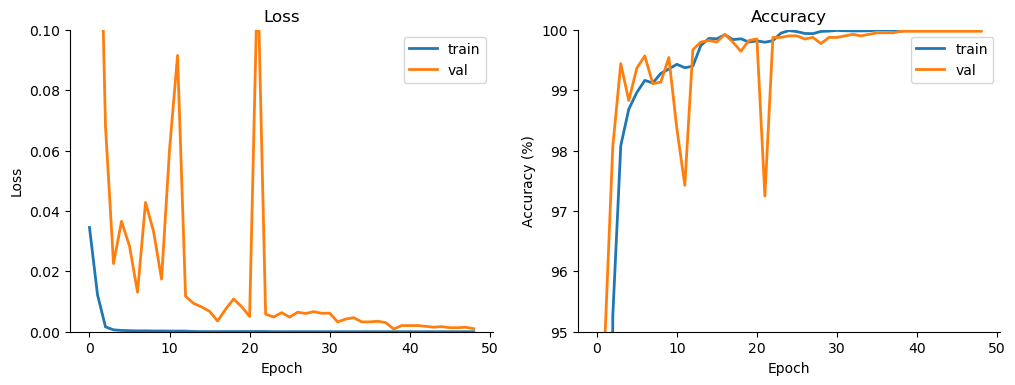

In [34]:
# Plot training and validation loss
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=100)
ax[0].plot(train_loss, label='train', lw=2)
ax[0].plot(val_loss, label='val', lw=2)
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
#ax[0].set_ylim([0, 0.1])
# remove right and top spines
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].plot(train_acc, label='train', lw=2)
ax[1].plot(val_acc, label='val', lw=2)
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend()
# remove right and top spines
ax[1].spines['right'].set_visible(False)    
ax[1].spines['top'].set_visible(False)
#ax[1].set_ylim([95, 100])